In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5a90f75d-a41b-3d6b-9d20-c7b89111c5cd)


In [2]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
import warnings
warnings.filterwarnings('ignore')

TensorFlow version: 2.18.0


In [6]:
# we will be uisng tensorflow datasets in this notebook
import tensorflow_datasets as tfds

In [7]:
# Get all the datasets in tfds
dataset_list = tfds.list_builders()

target_dataset = 'food101'
print(f"{target_dataset} in tensorflow datasets : {target_dataset in dataset_list}")

food101 in tensorflow datasets : True


In [8]:
len(dataset_list)

1311

In [10]:
(train_data,test_data),ds_info = tfds.load(
    name='food101',
    split=['train','validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.0QSO3D_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.0QSO3D_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [13]:
class_names = ds_info.features['label'].names
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [15]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
for image, label in train_one_sample:
    print(f"""
    Image shape : {image.shape}
    Image dtype : {image.dtype}
    Target class from Food101 (tensor form) : {label}
    Class name (str) : {class_names[int(label.numpy())]}
    """)


    Image shape : (512, 512, 3)
    Image dtype : <dtype: 'uint8'>
    Target class from Food101 (tensor form) : 16
    Class name (str) : cheesecake
    


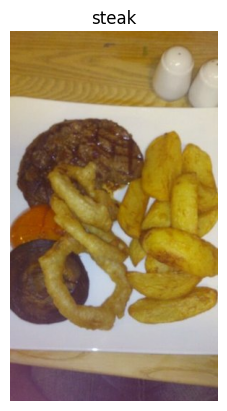

In [19]:
# printitng the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [20]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Creating preprocessing functions for our data

In [21]:
def preprocess(image,label,image_shape=[224,224]):
  image = tf.image.resize(image,size=image_shape)
  return tf.cast(image,tf.float32),label

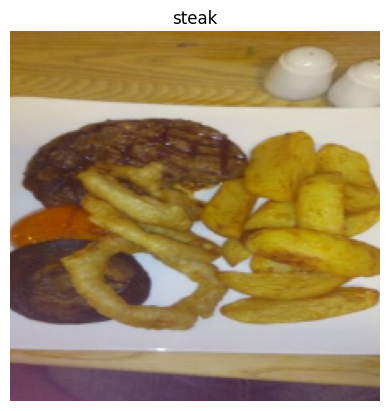

In [28]:
preprocessed_img = preprocess(image,label)[0]
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [29]:
# map processing the function and parallelize
train_data = train_data.map(map_func=preprocess,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# same for the test data but dont shuffle it
test_data = test_data.map(map_func=preprocess,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
train_data,test_data
# class_names[label]

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Create Modelling callbacks

In [31]:
# checkpoint path
checkpoint_path = "model_checkpoints/model1.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

In [32]:
# Setup the mixed precision training
# it uses the mix of float32 and float16 and it works well on gpu's

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [33]:
# check the mixed precision is used or not
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

### Data Augmentation Layer

In [34]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2)
],name="Augmentation_layer")

## Building feature extraction model

In [35]:
# we will be using EfficientNetB0
from tensorflow.keras import layers

# creating the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False,weights="imagenet")
base_model.trainable=False

# Creating the inputs
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./225)
x = base_model(inputs,training=False)

# Add pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="Pooling_layer")(x)

# output layers
x =  layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)

# adding inputs and outputs to the model
model = tf.keras.Model(inputs,outputs)

# compiling the model
model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam()
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [37]:
# checking if the mixed precision is used or not
for layer in model.layers:
    print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
Pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [38]:
# checking dtype policy in the effecientnet model
for layer in base_model.layers[:10]:
    print(layer.name,layer.dtype,layer.dtype_policy)

input_layer float32 <DTypePolicy "mixed_float16">
rescaling float32 <DTypePolicy "mixed_float16">
normalization float32 <DTypePolicy "mixed_float16">
rescaling_1 float32 <DTypePolicy "mixed_float16">
stem_conv_pad float32 <DTypePolicy "mixed_float16">
stem_conv float32 <DTypePolicy "mixed_float16">
stem_bn float32 <DTypePolicy "mixed_float16">
stem_activation float32 <DTypePolicy "mixed_float16">
block1a_dwconv float32 <DTypePolicy "mixed_float16">
block1a_bn float32 <DTypePolicy "mixed_float16">


### fitting the model

In [39]:
# turning warnings off except for errors
tf.get_logger().setLevel('ERROR')

In [41]:
history_feature_extraction = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks=[model_checkpoint]
)

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 152s 64ms/step - accuracy: 0.7554 - loss: 0.9237 - val_accuracy: 0.7352 - val_loss: 0.9448
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 151s 63ms/step - accuracy: 0.7645 - loss: 0.8837 - val_accuracy: 0.7378 - val_loss: 0.9610
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.7732 - loss: 0.8481 - val_accuracy: 0.7365 - val_loss: 0.9570
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 203s 85ms/step - accuracy: 0.7797 - loss: 0.8220 - val_accuracy: 0.7394 - val_loss: 0.9626
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 85ms/step - accuracy: 0.7842 - loss: 0.7939 - val_accuracy: 0.7349 - val_loss: 0.9699


In [42]:
result_feature_extraction_model = model.evaluate(test_data)
result_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7308 - loss: 0.9839


[0.9772665500640869, 0.7333069443702698]

In [43]:
# creating a new functions and loading old weights to it
def create_model():
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
    base_model.trainable=False

    #giving inputs
    inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")
    x = base_model(inputs,training=False)

    # giving pooling layer
    x = layers.GlobalAveragePooling2D(name="Pooling_layer")(x)

    # outout layer
    x = layers.Dense(len(class_names))(x)
    outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)

    # create the model
    model = tf.keras.Model(inputs,outputs)
    return model

In [44]:
created_model = create_model()

# compile the model
created_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam()
)

In [45]:
# load the weights of the old model
created_model.load_weights(checkpoint_path)

In [46]:
# evaluate the loaded weight model
results_with_loaded_weight_model = created_model.evaluate(test_data)
results_with_loaded_weight_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 64ms/step - accuracy: 0.7326 - loss: 0.9724


[0.9713138341903687, 0.7341386079788208]

In [47]:
# Save the model
created_model.save("model.keras")

## Fine Tuning our model

In [48]:
# fine tuning works well when we have a lot of data

In [49]:
# loading the saved model
loaded_model = tf.keras.models.load_model("model.keras")
loaded_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437,720 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,768 (1010.82 KB)

In [50]:
# evaluate the laoded model
loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 61ms/step - accuracy: 0.7323 - loss: 0.9731


[0.9713138341903687, 0.7341386079788208]

In [51]:
# activate the trainable parameter in our loaded_model so we can use it for fine tuning
for layer in loaded_model.layers:
    layer.trainable = True
    print(f"{layer.name} --- {layer.trainable}")

input_layer --- True
efficientnetb0 --- True
Pooling_layer --- True
dense_1 --- True
softmax_float32 --- True


In [52]:
# checking mixed precision
for layer in loaded_model.layers[1].layers[:10]:
    print(layer.name,layer.dtype_policy)

input_layer_1 <DTypePolicy "mixed_float16">
rescaling_2 <DTypePolicy "mixed_float16">
normalization_1 <DTypePolicy "mixed_float16">
rescaling_3 <DTypePolicy "mixed_float16">
stem_conv_pad <DTypePolicy "mixed_float16">
stem_conv <DTypePolicy "mixed_float16">
stem_bn <DTypePolicy "mixed_float16">
stem_activation <DTypePolicy "mixed_float16">
block1a_dwconv <DTypePolicy "mixed_float16">
block1a_bn <DTypePolicy "mixed_float16">


In [53]:
len(loaded_model.layers[1].layers)

238

we will be using EarylyStopping because we have many trainable layer and it could take days to train this model

In [61]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=3)

# create the new checkpoint with the val_loss
checkpoint_path = "fine_tune/loaded_model.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True

)

the most important model hyperparamter is learning rate
<br>
`ReduceLROnPlateau` will be used to tune the learning rate

In [62]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2, # multiply by 0.2
    patience = 2,
    verbose=1,
    min_lr=1e-7
)

In [63]:
loaded_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

In [64]:
callbacks = [early_stopping, reduce_lr, model_checkpoint]

history_fine_tune = loaded_model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks = callbacks
)

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 356s 110ms/step - accuracy: 0.8059 - loss: 0.7116 - val_accuracy: 0.8085 - val_loss: 0.6744 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 207s 86ms/step - accuracy: 0.8668 - loss: 0.4882 - val_accuracy: 0.8234 - val_loss: 0.6500 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 258s 84ms/step - accuracy: 0.9076 - loss: 0.3469 - val_accuracy: 0.8223 - val_loss: 0.6600 - learning_rate: 1.0000e-04
Epoch 4/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9379 - loss: 0.2424
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 265s 86ms/step - accuracy: 0.9379 - loss: 0.2424 - val_accuracy: 0.8263 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 264s 87ms/step - accuracy: 0.9637 - loss: 0.1554 - val_accuracy: 0.8321 - val_loss: 0.6217 - learning_rate: 2.0000e-05
Epoch 6/100
2368/2368 ━━━━━━━━━━━━

In [65]:
print(type(early_stopping))
print(type(reduce_lr))
print(type(model_checkpoint))


<class 'keras.src.callbacks.early_stopping.EarlyStopping'>
<class 'keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau'>
<class 'keras.src.callbacks.model_checkpoint.ModelCheckpoint'>


In [66]:
loaded_model.save("fine_tune_model.keras")

In [68]:
fine_tuned_model = tf.keras.models.load_model('fine_tune_model.keras')

In [69]:
final_model_results = fine_tuned_model.evaluate(test_data)
final_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - accuracy: 0.8342 - loss: 0.6341


[0.64007169008255, 0.8333069086074829]

In [70]:
!zip -r full_workspace.zip /content/


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.07.10/ (stored 0%)
  adding: content/.config/logs/2025.07.10/13.34.37.820504.log (deflated 58%)
  adding: content/.config/logs/2025.07.10/13.33.45.486303.log (deflated 92%)
  adding: content/.config/logs/2025.07.10/13.34.38.537881.log (deflated 57%)
  adding: content/.config/logs/2025.07.10/13.34.23.548658.log (deflated 86%)
  adding: content/.config/logs/2025.07.10/13.34.14.671755.log (deflated 58%)
  adding: content/.config/logs/2025.07.10/13.34.29.179991.log (deflated 58%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config

In [72]:
from google.colab import files
files.download("full_workspace.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>